# TDS Final Project - Opal & Gil

# 0. Installs & Imports

In [45]:
!pip install --upgrade pip
!pip install shap

In [121]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from sklearn.metrics import classification_report
from sklearn import svm as skl_svm

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance

# 1. Load the datasets

Dataset 1 - [Iris Species](https://www.kaggle.com/datasets/uciml/iris): Data of different iris plants classified into three species.

Dataset 2 - [Titanic passengers](https://www.kaggle.com/competitions/titanic/data) : This data contains the detailes of the passengers classified to survived or to not survived from the disaster.

Dataset 3 - [Cancer detection](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data): Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

Dataset 4 - [Stress detection in sleep](https://www.kaggle.com/datasets/laavanya/human-stress-detection-in-and-through-sleep): Sleeping parameters captured for sleep study be an IoT sensor.

In [47]:
IRIS_URL = "https://raw.githubusercontent.com/opalpeltzman/YouTubeLikesPrediction/main/final_project/datasets/IRIS.csv"
TITANIC_URL = "https://raw.githubusercontent.com/opalpeltzman/YouTubeLikesPrediction/main/final_project/datasets/titanic.csv"
CANCER_URL = "https://raw.githubusercontent.com/opalpeltzman/YouTubeLikesPrediction/main/final_project/datasets/cancer.csv"
SLEEPING_URL = "https://raw.githubusercontent.com/opalpeltzman/YouTubeLikesPrediction/main/final_project/datasets/sleeping.csv"

IRIS_DATASET = "iris_dataset"
TITANIC_DATASET = "titanic_dataset"
CANCER_DATASET = "cancer_dataset"
SLEEPING_DATASET = "sleeping_dataset"

SEED = 1337
np.random.seed(SEED)

def reload_datasets():
    return { IRIS_DATASET: pd.read_csv(IRIS_URL),
             TITANIC_DATASET: pd.read_csv(TITANIC_URL),
             SLEEPING_DATASET: pd.read_csv(SLEEPING_URL),
             CANCER_DATASET: pd.read_csv(CANCER_URL)
           }

dfs = reload_datasets()

# 2. Models Definitions

In [122]:
def KNN(X_train, Y_train, X_test, dataset_name, class_names):
    """Train KNN model, generate SHAP values and predictions"""
    print(f"Executing KNN on {dataset_name}")
    plt.subplot(121)
    
    # Train model
    knn = neighbors.KNeighborsClassifier(n_neighbors=15, weights="distance")
    knn.fit(X_train.values, Y_train)
    
    # Generate SHAP values
    knn_explainer = shap.KernelExplainer(knn.predict, X_test)
    knn_shap_values = knn_explainer.shap_values(X_test)
    
    # Plot and save SHAP summary
    shap.summary_plot(knn_shap_values, X_test, show=False)
    plt.savefig(f"./graphs/{dataset_name}_KNN.png")

    return knn.predict(X_test)

def SVM(X_train, Y_train, X_test, dataset_name, class_names):
    """Train SVM model, generate SHAP values and predictions"""
    print(f"Executing SVM on {dataset_name}")
    plt.subplot(121)
    
    # Train model
    svm = skl_svm.SVC(gamma="scale", decision_function_shape="ovo")
    svm.fit(X_train.values, Y_train)
    
    # Generate SHAP values
    svm_explainer = shap.KernelExplainer(svm.predict, X_test)
    svm_shap_values = svm_explainer.shap_values(X_test)
    
    # Plot and save SHAP summary
    shap.summary_plot(svm_shap_values, X_test, show=False)
    plt.savefig(f"./graphs/{dataset_name}_SVM.png")

    return svm.predict(X_test)

def Decision_Tree(X_train, Y_train, X_test, dataset_name, class_names):
    """Train Decision Tree model, generate SHAP values and predictions"""
    print(f"Executing Decision_Tree on {dataset_name}")
    
    # Train model
    model = DecisionTreeClassifier(random_state=1, max_depth=5)
    model.fit(X_train, Y_train)
    
    # Generate SHAP values
    decision_tree_explainer = shap.TreeExplainer(model)
    decision_tree_shap_values = decision_tree_explainer.shap_values(X_test)
    
    # Plot and save SHAP summary
    shap.summary_plot(
        decision_tree_shap_values, 
        X_test, 
        show=False, 
        class_names=class_names
    )
    plt.savefig(f"./graphs/{dataset_name}_decision_tree.png")

    return model.predict(X_test)

def Logistic_Regression(X_train, Y_train, X_test, dataset_name, class_names):
    """Train Logistic Regression model, generate SHAP values and predictions"""
    print(f"Executing Logistic_Regression on {dataset_name}")
    
    # Train model
    logistic_reg_model = LogisticRegression(solver="lbfgs")
    logistic_reg_model.fit(X_train, Y_train)
    
    # Generate SHAP values
    logistic_reg_explainer = shap.KernelExplainer(logistic_reg_model.predict, X_test)
    logistic_reg_shap_values = logistic_reg_explainer.shap_values(X_test)
    
    # Plot and save SHAP summary
    shap.summary_plot(logistic_reg_shap_values, X_test, show=False)
    plt.savefig(f"./graphs/{dataset_name}_logistic_regression.png")

    return logistic_reg_model.predict(X_test)

In [123]:
models = {
    "KNN": lambda X_train, Y_train, X_test, dataset_name, class_names: KNN(
        X_train, Y_train, X_test, dataset_name, class_names
    ),
    "SVM": lambda X_train, Y_train, X_test, dataset_name, class_names: SVM(
        X_train, Y_train, X_test, dataset_name, class_names
    ),
    "Decision_Tree": lambda X_train, Y_train, X_test, dataset_name, class_names: Decision_Tree(
        X_train, Y_train, X_test, dataset_name, class_names
    ),
    "Logistic_Regression": lambda X_train, Y_train, X_test, dataset_name, class_names: Logistic_Regression(
        X_train.values, Y_train, X_test, dataset_name, class_names
    ),
}

## 2.1 XGBOOST model

We try to compare between the results of SHAP with the above models and the result of the tree-based XGBOOST model.

In [124]:
def XGBoostClassifier(X_train, Y_train, dataset_name):
    """Train XGBoost model and plot feature importance"""
    print(f"Executing XGBoostClassifier on {dataset_name}")

    # Train model
    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, Y_train)

    # Plot and save feature importance
    plot_importance(xgb_model)
    pyplot.show()
    plt.savefig(f"./graphs/{dataset_name}_XGBOOST.png")

    return xgb_model.predict(X_train)

# 3. Preprocess the data

In [51]:
def preprocess_dataset(name, dataset):
    """Preprocess different datasets by selecting relevant features and target variables.
    
    Args:
        name (str): Name of the dataset to preprocess
        dataset (pd.DataFrame): Input dataset
        
    Returns:
        tuple: (X, Y) where X contains features and Y contains target variable
    """
    preprocessing_configs = {
        "iris_dataset": {
            "target": "species",
            "features": ["sepal_length", "sepal_width", "petal_length", "petal_width"]
        },
        "titanic_dataset": {
            "target": "Survived", 
            "features": ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Cabin", "Embarked"]
        },
        "sleeping_dataset": {
            "target": "sl",
            "features": ["sr1", "rr", "t", "lm", "bo", "rem", "sr2", "hr"],
            "preprocessing": lambda df: df.assign(sl=df["sl"].astype(int))
        },
        "cancer_dataset": {
            "target": "diagnosis",
            "features": [
                "radius_mean", "texture_mean", "perimeter_mean", "area_mean",
                "smoothness_mean", "compactness_mean", "concavity_mean", 
                "concave points_mean", "symmetry_mean", "fractal_dimension_mean",
                "radius_se", "texture_se", "perimeter_se", "area_se",
                "smoothness_se", "compactness_se", "concavity_se",
                "concave points_se", "symmetry_se", "fractal_dimension_se",
                "radius_worst", "texture_worst", "perimeter_worst", "area_worst",
                "smoothness_worst", "compactness_worst", "concavity_worst",
                "concave points_worst", "symmetry_worst", "fractal_dimension_worst"
            ]
        }
    }
    
    if name not in preprocessing_configs:
        raise ValueError(f"Unknown dataset name: {name}")
        
    config = preprocessing_configs[name]
    
    # Apply any preprocessing steps
    if "preprocessing" in config:
        dataset = config["preprocessing"](dataset)
        
    X = dataset[config["features"]]
    Y = dataset[config["target"]]
    
    return X, Y

## 3.1 Models training

In [ ]:
shap.initjs()
np.random.seed(0)


def models_train(X_train, y_train, X_test, y_test, dataset_name, target_strings):
    """Train and evaluate multiple models on the given dataset.
    
    Args:
        X_train: Training features
        y_train: Training labels 
        X_test: Test features
        y_test: Test labels
        dataset_name: Name of the dataset being used
        target_strings: List of target class names
        
    Returns:
        None. Prints classification reports and displays plots for each model.
    """
    for model_name, model_fn in models.items():
        # Train model and get predictions
        y_predict = model_fn(X_train, y_train, X_test, dataset_name, target_strings)
        
        # Print classification metrics
        print(f"\nResults for {model_name}:")
        print(classification_report(y_test, y_predict, target_names=target_strings))
        
        # Show generated plots
        plt.show()

## 3.2 Iris Dataset

### 3.2.1 EDA IRIS - Data Exploration

In [128]:
dataset = dfs[IRIS_DATASET]
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


### 3.2.2 labels organization


In [129]:
print(*list(dataset["species"]))

Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-setosa Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor Iris-versicolor 

We can see that the column 'species' is ordered, so we shuffle it

In [130]:
dataset = shuffle(dataset)

In [131]:
print(*list(dataset["species"]))

Iris-setosa Iris-versicolor Iris-versicolor Iris-setosa Iris-virginica Iris-virginica Iris-setosa Iris-setosa Iris-setosa Iris-versicolor Iris-versicolor Iris-setosa Iris-virginica Iris-versicolor Iris-virginica Iris-versicolor Iris-virginica Iris-virginica Iris-versicolor Iris-versicolor Iris-setosa Iris-versicolor Iris-versicolor Iris-versicolor Iris-virginica Iris-versicolor Iris-versicolor Iris-virginica Iris-virginica Iris-setosa Iris-versicolor Iris-versicolor Iris-versicolor Iris-virginica Iris-setosa Iris-setosa Iris-virginica Iris-virginica Iris-virginica Iris-setosa Iris-versicolor Iris-setosa Iris-setosa Iris-versicolor Iris-setosa Iris-virginica Iris-versicolor Iris-versicolor Iris-setosa Iris-virginica Iris-setosa Iris-setosa Iris-setosa Iris-versicolor Iris-virginica Iris-versicolor Iris-setosa Iris-setosa Iris-versicolor Iris-setosa Iris-virginica Iris-versicolor Iris-versicolor Iris-versicolor Iris-setosa Iris-versicolor Iris-setosa Iris-setosa Iris-versicolor Iris-seto

In [132]:
(X,Y) = preprocess_dataset(IRIS_DATASET, dataset)

In [133]:
print(X.head())

     sepal_length  sepal_width  petal_length  petal_width
40            5.0          3.5           1.3          0.3
53            5.5          2.3           4.0          1.3
71            6.1          2.8           4.0          1.3
1             4.9          3.0           1.4          0.2
127           6.1          3.0           4.9          1.8


### 3.2.3 checking for missing values


In [134]:
print(X.isnull().sum())

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
dtype: int64


In [135]:
Y.value_counts()

species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

Text(0.5, 1.0, 'Distribution of Iris Species')

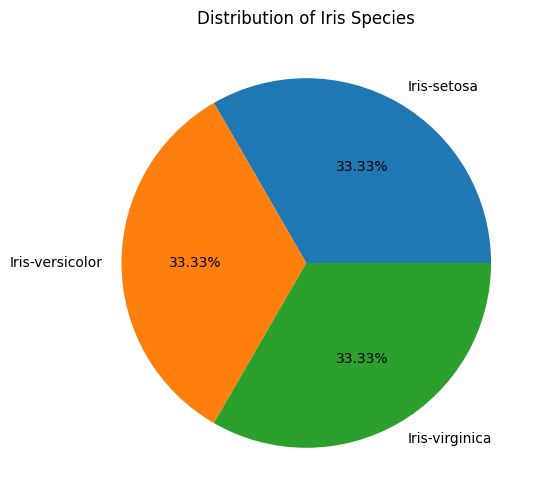

In [137]:
plt.figure(figsize=(10, 6))
plt.pie(Y.value_counts(), labels=Y.unique(), autopct='%1.2f%%')
plt.title("Distribution of Iris Species")

### 3.2.4 StratifiedShuffleSplit


We splits the data using StratifiedShuffleSplit in order to perseve the same labels ratio between train & test.

In [62]:
splitter = StratifiedShuffleSplit(
    n_splits=1, random_state=12, test_size=0.2
)  # we can make a number of combinations of split
# But we are interested in only one.

for train, test in splitter.split(X, Y):  # this will splits the index
    X_train = X.iloc[train]
    y_train = Y.iloc[train]
    X_test = X.iloc[test]
    y_test = Y.iloc[test]
print(y_train.value_counts())
print(y_test.value_counts())

species
Iris-virginica     40
Iris-setosa        40
Iris-versicolor    40
Name: count, dtype: int64
species
Iris-virginica     10
Iris-setosa        10
Iris-versicolor    10
Name: count, dtype: int64


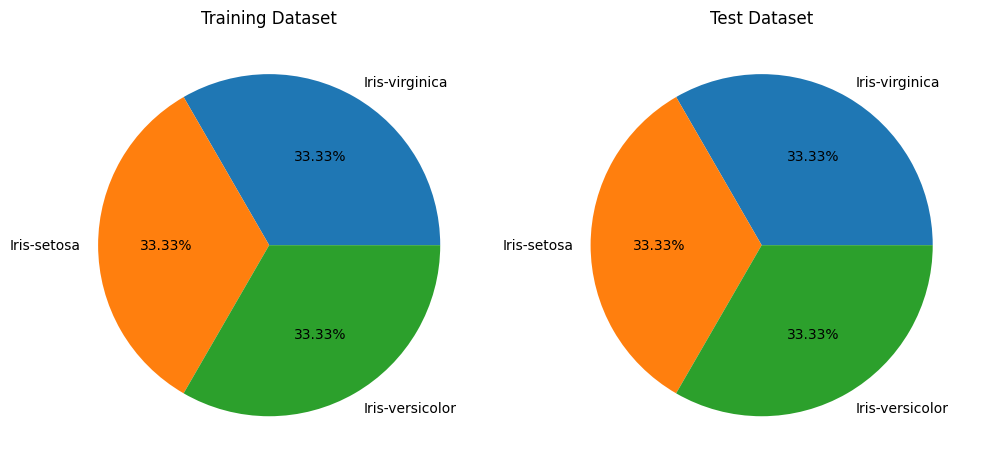

In [63]:
plt.figure(figsize=(10, 15))

plt.subplot(121)
plt.pie(y_train.value_counts(), labels=y_train.unique(), autopct="%1.2f%%")
plt.title("Training Dataset")

plt.subplot(122)
plt.pie(y_test.value_counts(), labels=y_test.unique(), autopct="%1.2f%%")
plt.title("Test Dataset")

plt.tight_layout()

### 3.2.5 Transforming the y string label using LabelEnconder
we also need to make sure we set the same label encoding for both y_train & y_test


In [64]:
le = preprocessing.LabelEncoder()
trained_le = le.fit(y_train)

y_train = trained_le.transform(y_train)
y_test = trained_le.transform(y_test)

### 3.2.6 Get Class Names


In [65]:
Y.unique()

array(['Iris-virginica', 'Iris-versicolor', 'Iris-setosa'], dtype=object)

In [66]:
print(len(Y.unique()))
target_strings = le.inverse_transform(np.arange(len(Y.unique())))
target_strings

3


array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

### 3.2.7 Train models with SHAP


Executing KNN on iris_dataset


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 37.61it/s]
X has feature names, but KNeighborsClassifier was fitted without feature names


                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



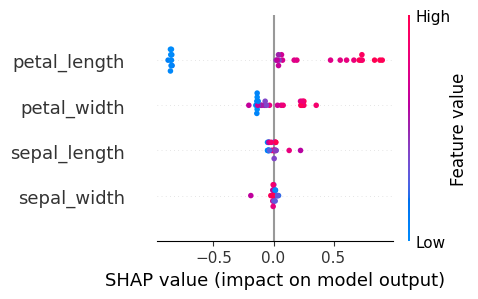

Executing SVM on iris_dataset


100%|██████████| 30/30 [00:00<00:00, 50.60it/s]
X has feature names, but SVC was fitted without feature names


                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



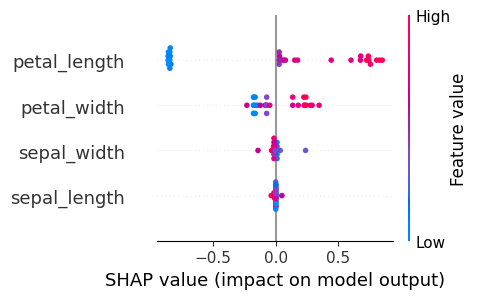

Executing Decision_Tree on iris_dataset
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.89      0.80      0.84        10
 Iris-virginica       0.82      0.90      0.86        10

       accuracy                           0.90        30
      macro avg       0.90      0.90      0.90        30
   weighted avg       0.90      0.90      0.90        30



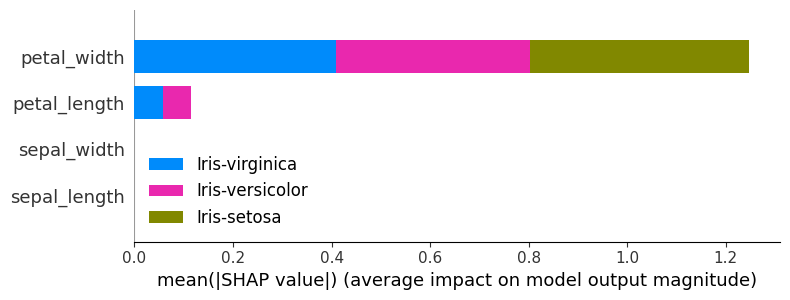

Executing Logistic_Regression on iris_dataset


100%|██████████| 30/30 [00:00<00:00, 64.14it/s]
X has feature names, but LogisticRegression was fitted without feature names


                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.80      0.89        10
 Iris-virginica       0.83      1.00      0.91        10

       accuracy                           0.93        30
      macro avg       0.94      0.93      0.93        30
   weighted avg       0.94      0.93      0.93        30



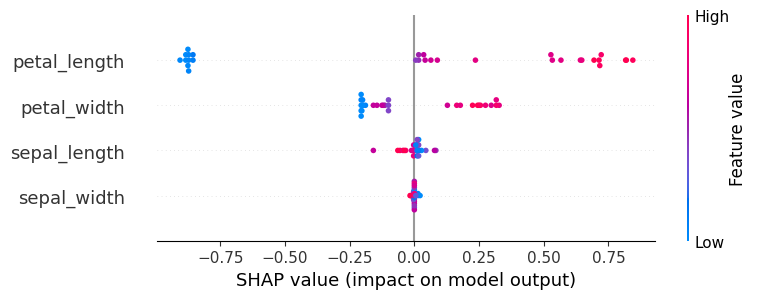

In [67]:
models_train(X_train, y_train, X_test, y_test, IRIS_DATASET, target_strings)

### 3.2.8 XGBOOST


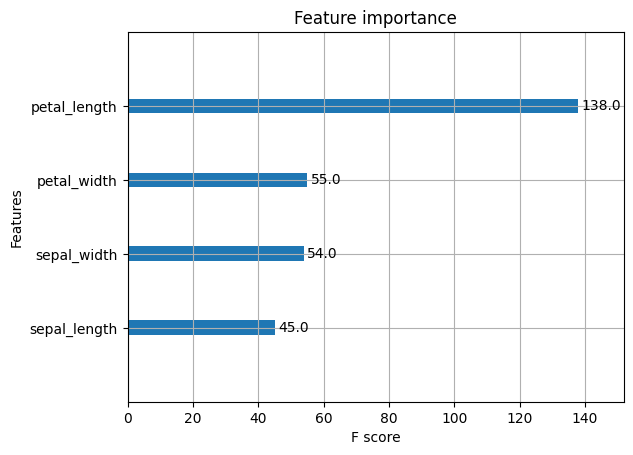

<Figure size 640x480 with 0 Axes>

In [68]:
XGBoostClassifier(X_train, y_train, IRIS_DATASET)

### 3.2.9 Feature Selection
From the graphs above we can see that half of the models ranked 'sepal length' as the least important, and half of the models ranked 'sepal width' as the least important. However, the XGBOOST model ranked 'sepal length' as the least important too. Therefore, we choosh to select all features without 'sepal length' and train the models again.




In [69]:
X_train = X_train.drop(columns=["sepal_length"])
X_test = X_test.drop(columns=["sepal_length"])

Executing KNN on iris_dataset


100%|██████████| 30/30 [00:00<00:00, 69.69it/s]


                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



X has feature names, but KNeighborsClassifier was fitted without feature names


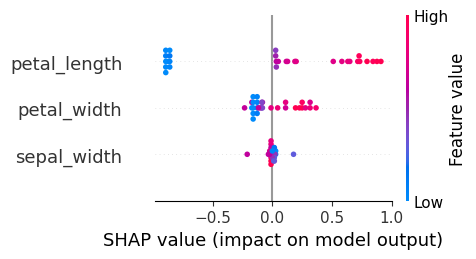

Executing SVM on iris_dataset


100%|██████████| 30/30 [00:00<00:00, 102.42it/s]
X has feature names, but SVC was fitted without feature names


                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



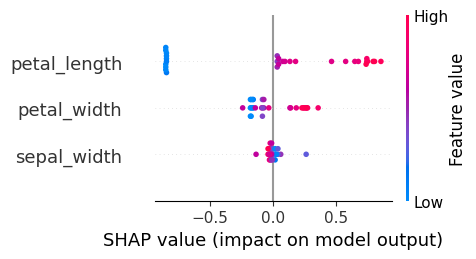

Executing Decision_Tree on iris_dataset
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.89      0.80      0.84        10
 Iris-virginica       0.82      0.90      0.86        10

       accuracy                           0.90        30
      macro avg       0.90      0.90      0.90        30
   weighted avg       0.90      0.90      0.90        30



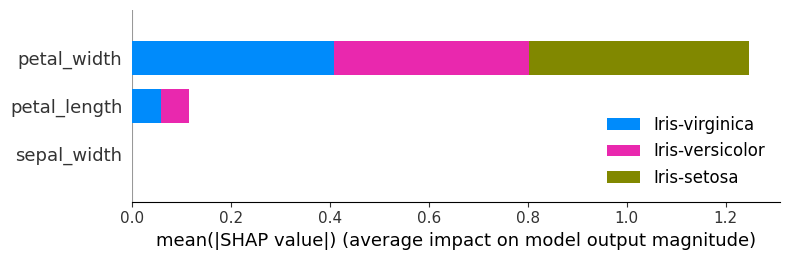

Executing Logistic_Regression on iris_dataset


100%|██████████| 30/30 [00:00<00:00, 116.18it/s]
X has feature names, but LogisticRegression was fitted without feature names


                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.80      0.89        10
 Iris-virginica       0.83      1.00      0.91        10

       accuracy                           0.93        30
      macro avg       0.94      0.93      0.93        30
   weighted avg       0.94      0.93      0.93        30



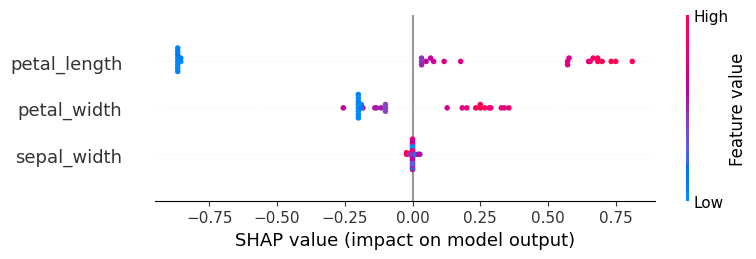

In [70]:
models_train(X_train, y_train, X_test, y_test, IRIS_DATASET, target_strings)

## 3.3 Titanic dataset


### 3.3.1 EDA TITANIC - Data Exploration


In [71]:
dataset = dfs[TITANIC_DATASET]
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [72]:
(X,Y) = preprocess_dataset(TITANIC_DATASET, dataset)

### 3.3.2 checking for missing values


In [73]:
print(X.isnull().sum())

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64


the Cabin column has too many NA values, hence its better to be dropped

the NA values of Age can be filled by mean imputation, and of Embarked by mode imputation

In [74]:
X.loc[:, "Age"] = X["Age"].fillna(X["Age"].mean())
X.loc[:, "Embarked"] = X["Embarked"].fillna(X["Embarked"].mode()[0])
X = X.drop(["Cabin"], axis=1)

### 3.3.3 Features and Labels Organization

We should convert the categorical data values into numeric.

In [75]:
X["Sex"] = LabelEncoder().fit_transform(X["Sex"])
X["Embarked"] = LabelEncoder().fit_transform(X["Embarked"])

In [76]:
print(*list(dataset["Survived"]))

0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 

We can see that the column 'Survived' is already encoded

In [77]:
print(X.head())

   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0       3    1  22.0      1      0   7.2500         2
1       1    0  38.0      1      0  71.2833         0
2       3    0  26.0      0      0   7.9250         2
3       1    0  35.0      1      0  53.1000         2
4       3    1  35.0      0      0   8.0500         2


In [78]:
Y.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x14751638370>,
 [Text(-0.3925749350994583, 1.0275626113924428, '0'),
  Text(0.3925750313068116, -1.0275625746369201, '1')],
 [Text(-0.21413178278152267, 0.5604886971231505, '61.62%'),
  Text(0.21413183525826085, -0.5604886770746836, '38.38%')])

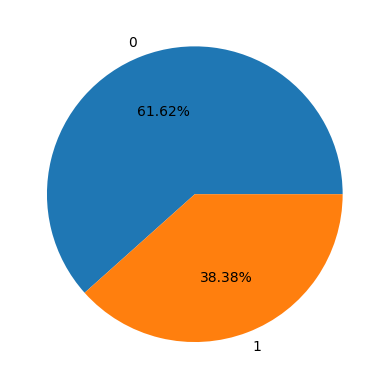

In [79]:
plt.pie(Y.value_counts(), labels=Y.unique(), autopct="%1.2f%%")

### 3.3.4 StratifiedShuffleSplit

We splits the data using StratifiedShuffleSplit in order to perseve the same labels ratio between train & test.

In [80]:
splitter = StratifiedShuffleSplit(
    n_splits=1, random_state=12, test_size=0.2
)  # we can make a number of combinations of split
# But we are interested in only one.

for train, test in splitter.split(X, Y):  # this will splits the index
    X_train = X.iloc[train]
    y_train = Y.iloc[train]
    X_test = X.iloc[test]
    y_test = Y.iloc[test]
print(y_train.value_counts())
print(y_test.value_counts())

Survived
0    439
1    273
Name: count, dtype: int64
Survived
0    110
1     69
Name: count, dtype: int64


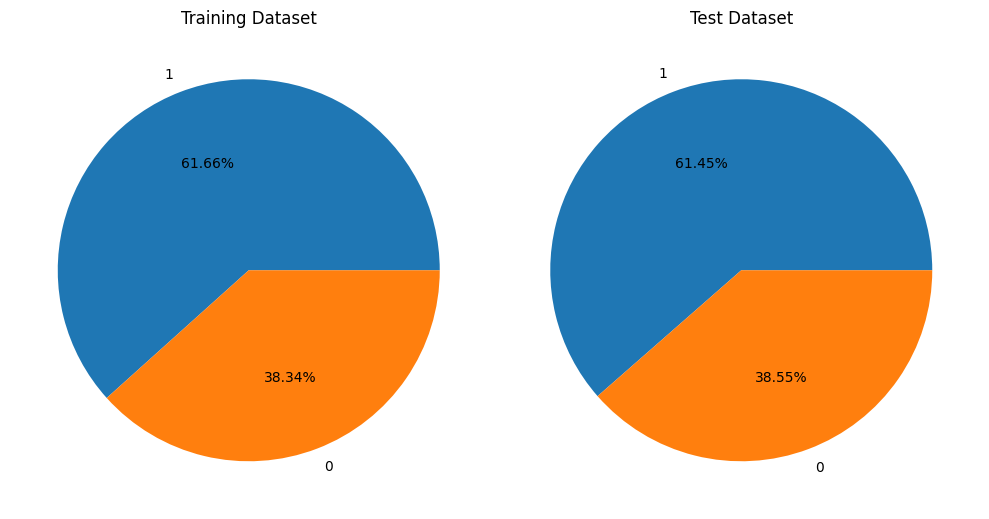

In [81]:
plt.figure(figsize=(10, 15))

plt.subplot(121)
plt.pie(y_train.value_counts(), labels=y_train.unique(), autopct="%1.2f%%")
plt.title("Training Dataset")

plt.subplot(122)
plt.pie(y_test.value_counts(), labels=y_test.unique(), autopct="%1.2f%%")
plt.title("Test Dataset")

plt.tight_layout()

### 3.3.5 Transforming the y string label using LabelEnconder
we also need to make sure we set the same label encoding for both y_train & y_test

In [82]:
le = preprocessing.LabelEncoder()
trained_le = le.fit(y_train)

y_train = trained_le.transform(y_train)
y_test = trained_le.transform(y_test)

### 3.3.6 Get Class Names

In [83]:
Y.unique()

array([0, 1], dtype=int64)

In [84]:
target_strings = np.array(["Not Survived", "Survived"])
target_strings

array(['Not Survived', 'Survived'], dtype='<U12')

### 3.3.7 Train models with SHAP

Using 179 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing KNN on titanic_dataset


100%|██████████| 179/179 [01:20<00:00,  2.22it/s]
X has feature names, but KNeighborsClassifier was fitted without feature names


              precision    recall  f1-score   support

Not Survived       0.75      0.85      0.80       110
    Survived       0.70      0.55      0.62        69

    accuracy                           0.74       179
   macro avg       0.73      0.70      0.71       179
weighted avg       0.73      0.74      0.73       179



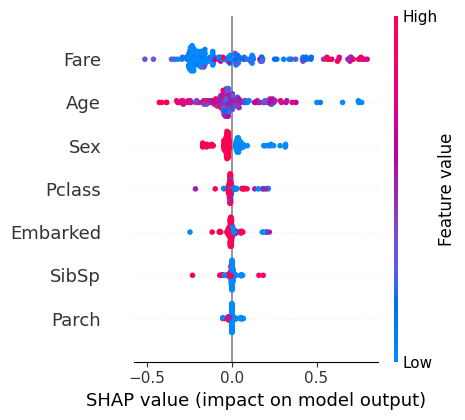

Using 179 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing SVM on titanic_dataset


100%|██████████| 179/179 [03:56<00:00,  1.32s/it]


              precision    recall  f1-score   support

Not Survived       0.67      0.94      0.78       110
    Survived       0.73      0.28      0.40        69

    accuracy                           0.68       179
   macro avg       0.70      0.61      0.59       179
weighted avg       0.70      0.68      0.64       179



X has feature names, but SVC was fitted without feature names


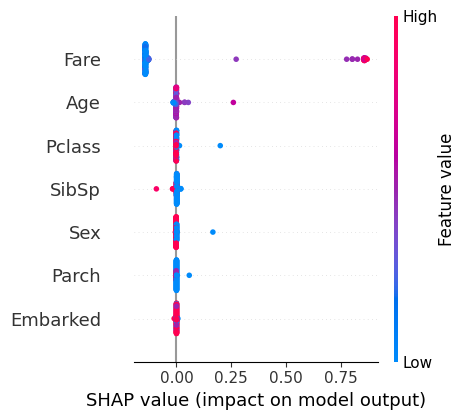

Executing Decision_Tree on titanic_dataset
              precision    recall  f1-score   support

Not Survived       0.83      0.87      0.85       110
    Survived       0.78      0.72      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



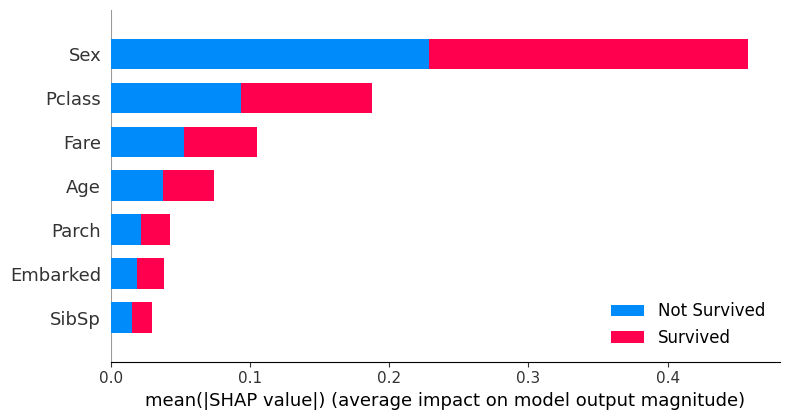

Using 179 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing Logistic_Regression on titanic_dataset


100%|██████████| 179/179 [00:28<00:00,  6.39it/s]


              precision    recall  f1-score   support

Not Survived       0.83      0.85      0.84       110
    Survived       0.76      0.72      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



X has feature names, but LogisticRegression was fitted without feature names


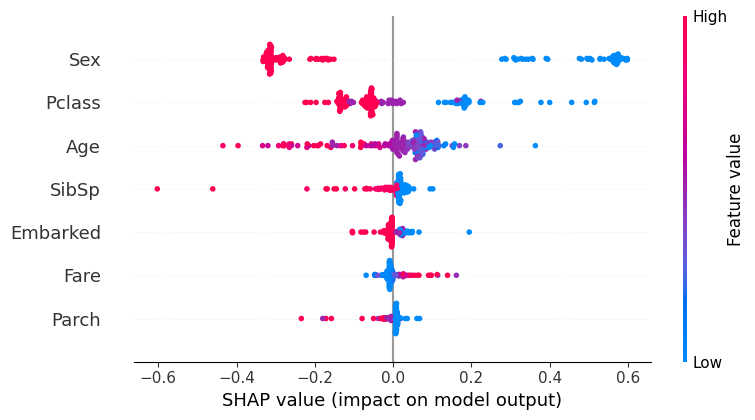

In [85]:
models_train(X_train, y_train, X_test, y_test, TITANIC_DATASET, target_strings)

### 3.3.8 XGBOOST

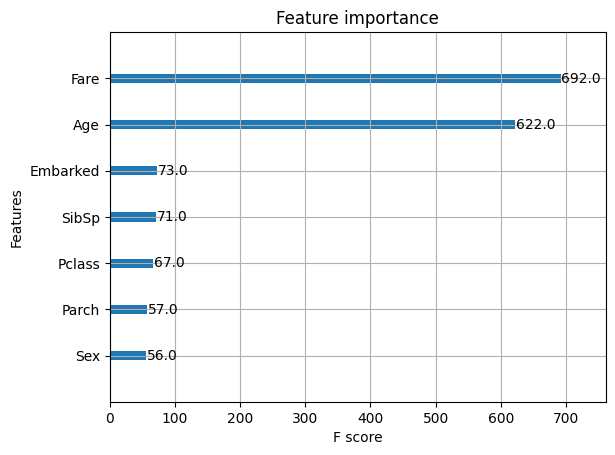

<Figure size 640x480 with 0 Axes>

In [86]:
XGBoostClassifier(X_train, y_train, TITANIC_DATASET)

### 3.3.9 Feature Selection
From the graphs above its seems that the feature 'parch' is less important. Therefore, we choosh to select all features without 'parch' and train the models again.


In [87]:
X_train = X_train.drop(columns=["Parch"])
X_test = X_test.drop(columns=["Parch"])

Using 179 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing KNN on titanic_dataset


100%|██████████| 179/179 [00:30<00:00,  5.87it/s]
X has feature names, but KNeighborsClassifier was fitted without feature names


              precision    recall  f1-score   support

Not Survived       0.76      0.87      0.81       110
    Survived       0.73      0.55      0.63        69

    accuracy                           0.75       179
   macro avg       0.74      0.71      0.72       179
weighted avg       0.75      0.75      0.74       179



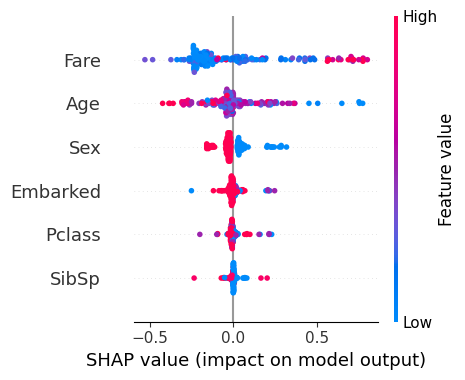

Using 179 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing SVM on titanic_dataset


100%|██████████| 179/179 [02:43<00:00,  1.09it/s]
X has feature names, but SVC was fitted without feature names


              precision    recall  f1-score   support

Not Survived       0.67      0.94      0.78       110
    Survived       0.72      0.26      0.38        69

    accuracy                           0.68       179
   macro avg       0.69      0.60      0.58       179
weighted avg       0.69      0.68      0.63       179



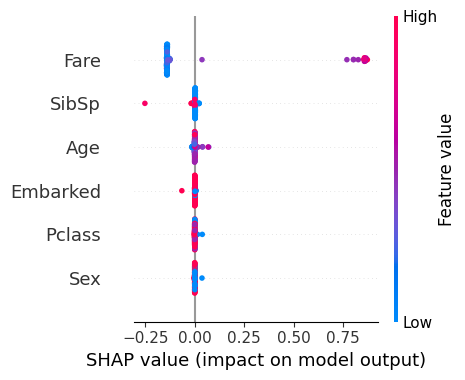

Executing Decision_Tree on titanic_dataset
              precision    recall  f1-score   support

Not Survived       0.82      0.89      0.85       110
    Survived       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



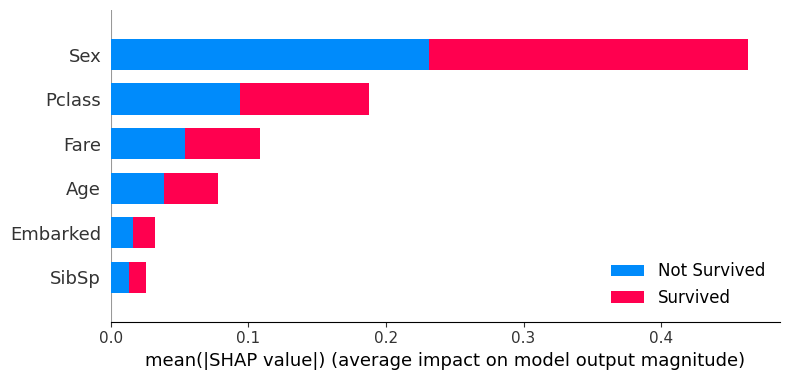

Using 179 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing Logistic_Regression on titanic_dataset


100%|██████████| 179/179 [00:32<00:00,  5.49it/s]
X has feature names, but LogisticRegression was fitted without feature names


              precision    recall  f1-score   support

Not Survived       0.84      0.85      0.85       110
    Survived       0.76      0.74      0.75        69

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



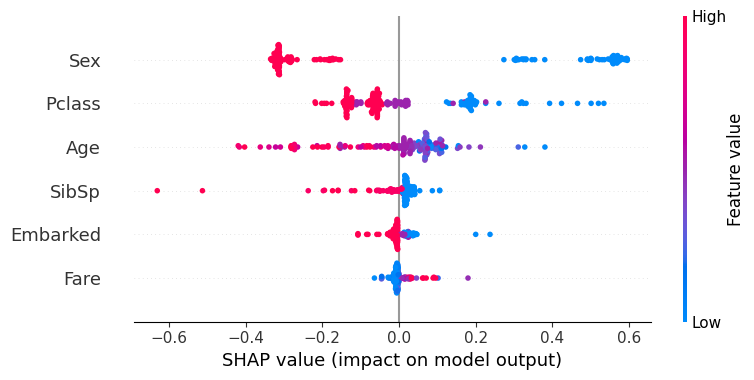

In [89]:
models_train(X_train, y_train, X_test, y_test, TITANIC_DATASET, target_strings)

## 3.4 Sleeping dataset



### 3.4.1 EDA SLEEPING - Data Exploration

In [90]:
dataset = dfs[SLEEPING_DATASET]
dataset.head()

,sr1,rr,t,lm,bo,rem,sr2,hr,sl
0,93.80,25.680,91.840,16.600,89.840,99.60,1.840,74.20,3
1,91.64,25.104,91.552,15.880,89.552,98.88,1.552,72.76,3
2,60.00,20.000,96.000,10.000,95.000,85.00,7.000,60.00,1
3,85.76,23.536,90.768,13.920,88.768,96.92,0.768,68.84,3
4,48.12,17.248,97.872,6.496,96.248,72.48,8.248,53.12,0


### 3.4.2 labels organization

In [91]:
print(*list(dataset["sl"]))

3 3 1 3 0 1 0 0 0 1 2 1 0 4 3 1 1 3 3 2 2 2 2 3 3 1 2 1 3 2 0 4 0 4 2 3 0 4 0 4 2 2 2 0 2 4 2 4 1 4 0 1 3 0 1 2 4 3 3 1 4 3 0 2 4 1 0 2 4 0 1 4 1 0 0 4 4 1 3 4 1 1 1 4 2 1 1 1 3 4 2 3 2 4 0 2 4 2 2 3 4 4 0 4 1 2 2 2 4 1 2 4 0 3 2 4 2 2 0 1 1 3 4 1 3 4 4 2 1 4 2 0 4 3 1 0 0 2 4 0 2 3 2 0 2 0 0 0 0 1 3 0 4 4 0 2 3 2 4 4 4 2 1 2 4 2 0 0 4 4 1 2 2 1 1 1 1 4 3 1 1 1 2 1 0 2 0 2 1 2 1 1 4 3 4 0 0 0 2 3 0 0 0 2 4 0 2 4 1 1 1 3 0 0 3 3 0 2 2 2 1 4 0 1 3 4 2 1 4 0 3 4 1 3 0 0 3 4 3 1 4 3 3 4 3 0 3 2 3 3 1 4 2 3 1 3 2 3 4 2 4 3 2 0 0 1 2 3 2 2 4 4 1 0 4 1 2 3 4 3 3 3 0 3 0 1 3 3 3 2 4 0 4 0 4 0 2 1 2 1 3 0 0 3 2 2 4 2 3 0 3 2 1 0 1 0 3 3 3 0 3 4 2 4 3 4 1 2 0 2 4 0 1 3 4 0 1 0 0 3 0 0 2 3 2 4 0 1 3 4 3 4 4 3 4 2 0 4 2 3 2 1 2 2 4 0 3 0 1 3 4 3 2 0 3 1 2 4 0 1 4 1 2 0 3 0 1 1 3 1 4 1 4 1 4 1 0 3 3 3 3 3 4 2 2 3 1 3 3 2 0 4 4 1 1 0 1 4 3 0 1 4 4 0 0 1 1 0 4 0 4 2 0 2 3 2 2 4 3 1 4 1 1 1 2 4 4 3 2 0 1 3 1 3 1 1 1 1 4 2 4 1 4 2 2 1 3 3 2 1 0 0 3 1 0 3 1 0 1 4 0 0 3 2 2 4 1 3 2 4 2 4 2 1 3 0 1 0 0 3 

In [92]:
(X,Y) = preprocess_dataset(SLEEPING_DATASET, dataset)

In [93]:
print(X.head())

     sr1      rr       t      lm      bo    rem    sr2     hr
0  93.80  25.680  91.840  16.600  89.840  99.60  1.840  74.20
1  91.64  25.104  91.552  15.880  89.552  98.88  1.552  72.76
2  60.00  20.000  96.000  10.000  95.000  85.00  7.000  60.00
3  85.76  23.536  90.768  13.920  88.768  96.92  0.768  68.84
4  48.12  17.248  97.872   6.496  96.248  72.48  8.248  53.12


### 3.4.3 checking for missing values

In [94]:
print(X.isnull().sum())

sr1    0
rr     0
t      0
lm     0
bo     0
rem    0
sr2    0
hr     0
dtype: int64


In [95]:
Y.value_counts()

sl
3    126
1    126
0    126
2    126
4    126
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x1474f4018e0>,
 [Text(0.8899186877588753, 0.6465637858537406, '3'),
  Text(-0.3399187231970732, 1.046162158377023, '1'),
  Text(-1.0999999999999988, -5.149471622296949e-08, '0'),
  Text(-0.33991862524830174, -1.0461621902025062, '2'),
  Text(0.8899187482945414, -0.6465637025335375, '4')],
 [Text(0.4854101933230228, 0.35267115592022213, '20.00%'),
  Text(-0.18541021265294902, 0.5706339045692853, '20.00%'),
  Text(-0.5999999999999993, -2.808802703071063e-08, '20.00%'),
  Text(-0.1854101592263464, -0.5706339219286397, '20.00%'),
  Text(0.4854102263424771, -0.3526711104728386, '20.00%')])

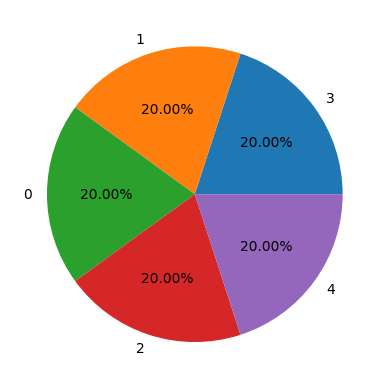

In [96]:
plt.pie(Y.value_counts(), labels=Y.unique(), autopct="%1.2f%%")

### 3.4.4 StratifiedShuffleSplit

We splits the data using StratifiedShuffleSplit in order to perseve the same labels ratio between train & test.

In [97]:
splitter = StratifiedShuffleSplit(
    n_splits=1, random_state=12, test_size=0.2
)  # we can make a number of combinations of split
# But we are interested in only one.

for train, test in splitter.split(X, Y):  # this will splits the index
    X_train = X.iloc[train]
    y_train = Y.iloc[train]
    X_test = X.iloc[test]
    y_test = Y.iloc[test]
print(y_train.value_counts())
print(y_test.value_counts())

sl
1    101
2    101
4    101
0    101
3    100
Name: count, dtype: int64
sl
3    26
4    25
1    25
2    25
0    25
Name: count, dtype: int64


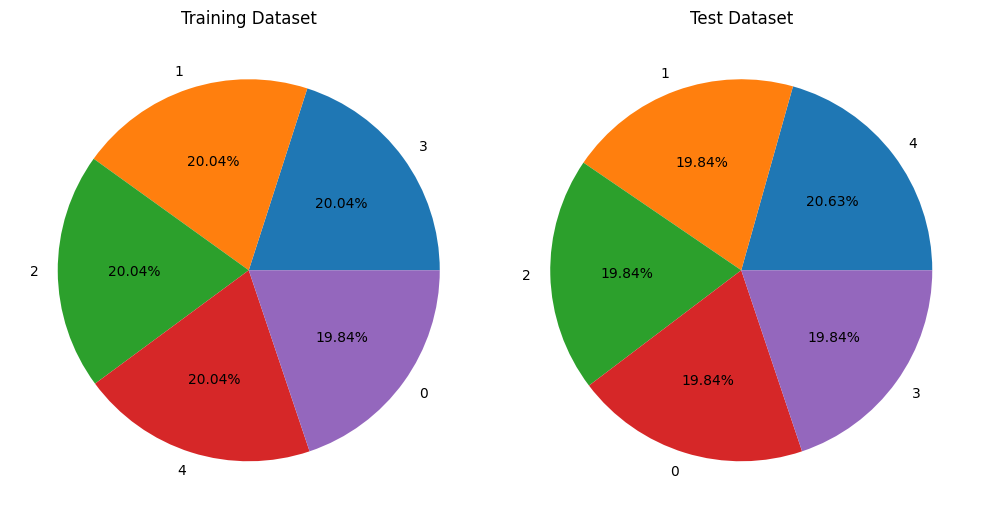

In [98]:
plt.figure(figsize=(10, 15))

plt.subplot(121)
plt.pie(y_train.value_counts(), labels=y_train.unique(), autopct="%1.2f%%")
plt.title("Training Dataset")

plt.subplot(122)
plt.pie(y_test.value_counts(), labels=y_test.unique(), autopct="%1.2f%%")
plt.title("Test Dataset")

plt.tight_layout()

### 3.4.5 Transforming the y string label using LabelEnconder
we also need to make sure we set the same label encoding for both y_train & y_test

In [99]:
le = preprocessing.LabelEncoder()
trained_le = le.fit(y_train)

y_train = trained_le.transform(y_train)
y_test = trained_le.transform(y_test)

### 3.4.6 Train models with SHAP

In [100]:
Y.unique()

array([3, 1, 0, 2, 4])

Using 126 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing KNN on sleeping_dataset


100%|██████████| 126/126 [01:17<00:00,  1.63it/s]
X has feature names, but KNeighborsClassifier was fitted without feature names


              precision    recall  f1-score   support

           3       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           0       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        25

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



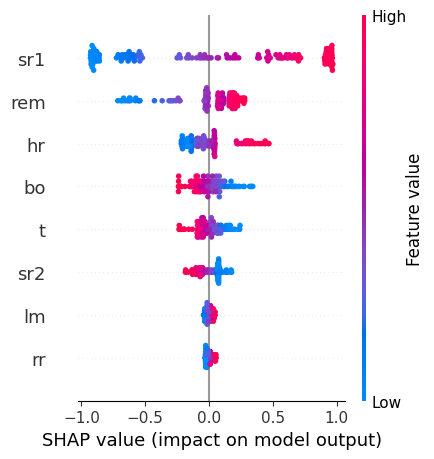

Using 126 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing SVM on sleeping_dataset


100%|██████████| 126/126 [06:29<00:00,  3.09s/it]
X has feature names, but SVC was fitted without feature names


              precision    recall  f1-score   support

           3       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           0       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        25

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



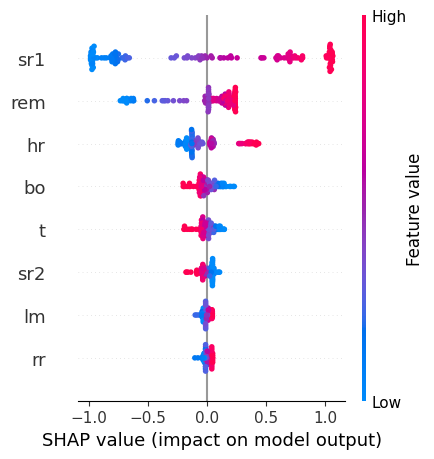

Executing Decision_Tree on sleeping_dataset
              precision    recall  f1-score   support

           3       1.00      0.96      0.98        25
           1       0.93      1.00      0.96        25
           0       1.00      0.96      0.98        25
           2       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        25

    accuracy                           0.98       126
   macro avg       0.99      0.98      0.98       126
weighted avg       0.99      0.98      0.98       126



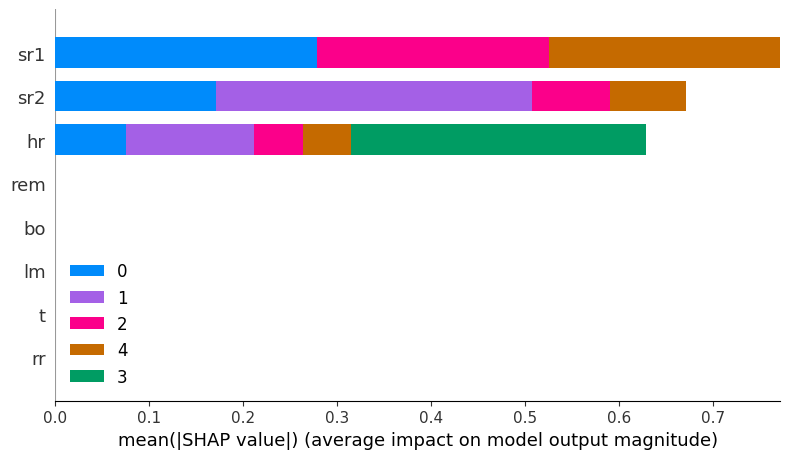

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Using 126 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing Logistic_Regression on sleeping_dataset


100%|██████████| 126/126 [00:21<00:00,  5.78it/s]
X has feature names, but LogisticRegression was fitted without feature names


              precision    recall  f1-score   support

           3       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           0       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        25

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



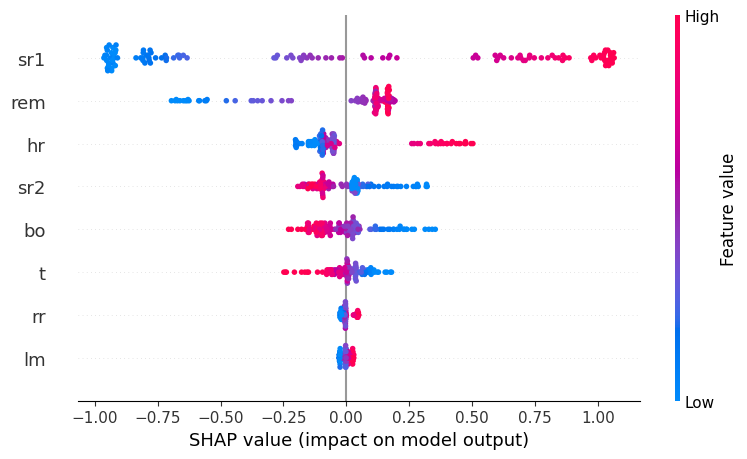

In [101]:
target_strings = np.array(["3", "1", "0", "2", "4"])  # Y.unique()
models_train(X_train, y_train, X_test, y_test, SLEEPING_DATASET, target_strings)

### 3.4.7 XGBOOST

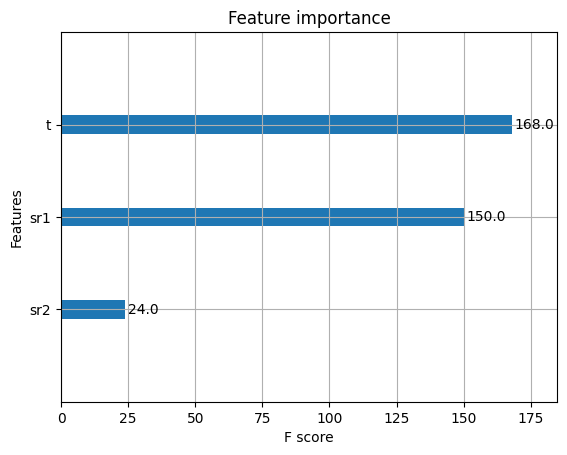

<Figure size 640x480 with 0 Axes>

In [102]:
XGBoostClassifier(X_train, y_train, SLEEPING_DATASET)

### 3.4.8 Feature Selection
From the graphs above we can see that the models ranked 'rr' as the least important. Therefore, we choosh to select all features without 'rr' and train the models again.


In [103]:
X_train = X_train.drop(columns=["rr"])
X_test = X_test.drop(columns=["rr"])

Using 126 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing KNN on sleeping_dataset


  0%|          | 0/126 [00:00<?, ?it/s]

100%|██████████| 126/126 [00:22<00:00,  5.50it/s]


              precision    recall  f1-score   support

           3       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           0       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        25

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



X has feature names, but KNeighborsClassifier was fitted without feature names


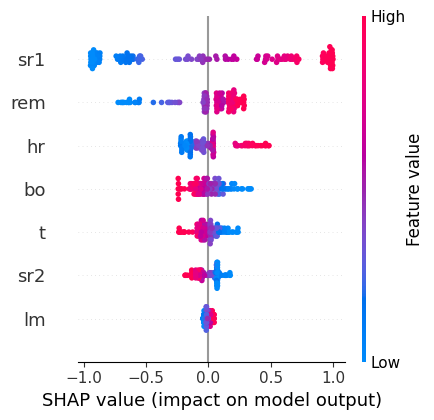

Using 126 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing SVM on sleeping_dataset


100%|██████████| 126/126 [01:28<00:00,  1.43it/s]


              precision    recall  f1-score   support

           3       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           0       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        25

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



X has feature names, but SVC was fitted without feature names


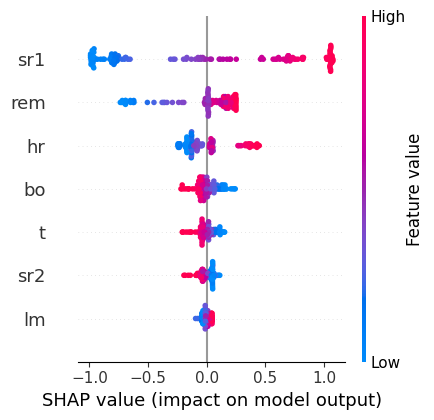

Executing Decision_Tree on sleeping_dataset
              precision    recall  f1-score   support

           3       1.00      0.96      0.98        25
           1       0.93      1.00      0.96        25
           0       1.00      0.96      0.98        25
           2       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        25

    accuracy                           0.98       126
   macro avg       0.99      0.98      0.98       126
weighted avg       0.99      0.98      0.98       126



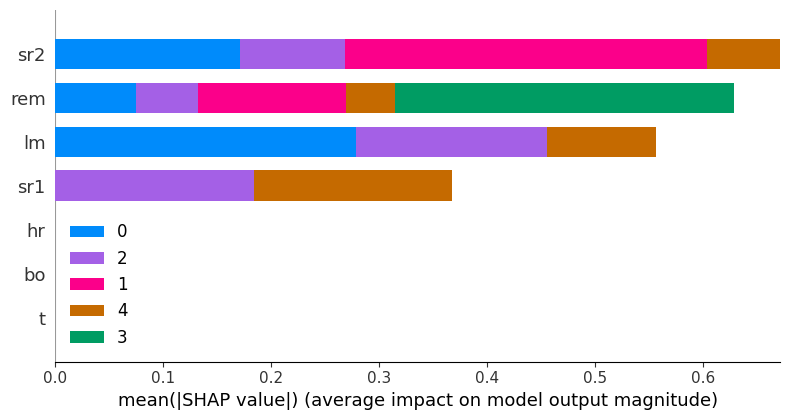

Executing Logistic_Regression on sleeping_dataset


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Using 126 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 126/126 [00:11<00:00, 11.11it/s]


              precision    recall  f1-score   support

           3       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           0       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        25

    accuracy                           1.00       126
   macro avg       1.00      1.00      1.00       126
weighted avg       1.00      1.00      1.00       126



X has feature names, but LogisticRegression was fitted without feature names


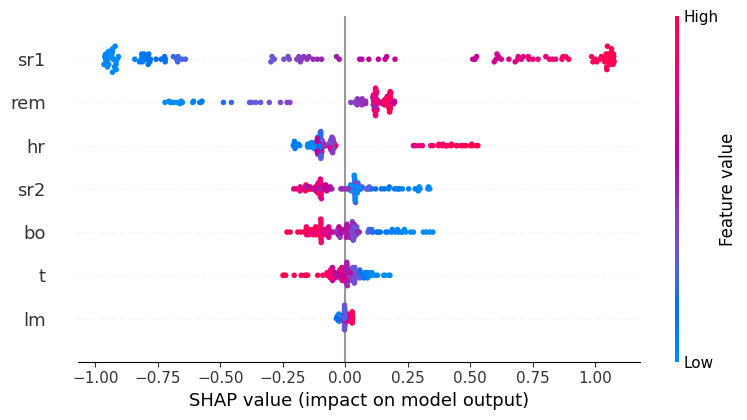

In [104]:
models_train(X_train, y_train, X_test, y_test, SLEEPING_DATASET, target_strings)

## 3.5 Cancer dataset

### 3.5.1 EDA CANCER - Data Exploration

In [105]:
dataset = dfs[CANCER_DATASET]
dataset.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### 3.5.2 labels organization

In [106]:
print(*list(dataset["diagnosis"]))

M M M M M M M M M M M M M M M M M M M B B B M M M M M M M M M M M M M M M B M M M M M M M M B M B B B B B M M B M M B B B B M B M M B B B B M B M M B M B M M B B B M M B M M M B B B M B B M M B B B M M B B B B M B B M B B B B B B B B M M M B M M B B B M M B M B M M B M M B B M B B M B B B B M B B B B B B B B B M B B B B M M B M B B M M B B M M B B B B M B B M M M B M B M B B B M B B M M B M M M M B M M M B M B M B B M B M M M M B B M M B B B M B B B B B M M B B M B B M M B M B B B B M B B B B B M B M M M M M M M M M M M M M M B B B B B B M B M B B M B B M B M M B B B B B B B B B B B B B M B B M B M B B B B B B B B B B B B B B M B B B M B M B B B B M M M B B B B M B M B M B B B M B B B B B B B M M M B B B B B B B B B B B M M B M M M B M M B B B B B M B B B B B M B B B M B B M M B B B B B B M B B B B B B B M B B B B B M B B M B B B B B B B B B B B B M B M M B M B B B B B M B B M B M B B M B M B B B B B B B B M M B B B B B B M B B B B B B B B B B M B B B B B B B M B M B B M B B B B B M M 

shuffle diagnosis column

In [107]:
dataset = shuffle(dataset)

In [108]:
print(*list(dataset['diagnosis']))

B B B B M B B M M B M B M M M B B M B B M M B M B B B B M B B M B M B B B B M B B B B B M B B B B M M B B M B B B M M M B B B M M B B B B M B B B B B B M B B B B B M B B M B B B B B M B B B B B M B B B M B M B M M M B B B B B B B M M B B B B B M B B M M B B M B B M B M B B B B B B M M B B B B B M M M M M M B B M M M M B B M B M M B B B B B B B B B M M M B B B M B M M M B B B B M B M B B B B M B M B M M M B B B B B B B B M B B M B B M M M B M B B B M M M B M B B M M B B M M B M M M M M B B B B M B B B M B M B B B B M M B B B M M M B B B M B B B B M B B B M M M B M B M B B B B M B B B M B B B B M B B M B M B B B B B B B B B B M M M B M B M B B B B M B M B B M M B M M M B M B M M M M M M B B B B M B B B M B M B B M M B B B M B B B M B M M M M B M M B M B B M B M B B B B B B B B M M B B B B M B M B M M M M B B B B M B M B B B B M M M B M B B B M B M M M B B B B B B M M B B B B B B B B B M B B B B B B M M M B B B B M B B B M B B M M M M M B B B M B B M M B B M B M B M M B B B B B B M B M M 

In [109]:
(X,Y) = preprocess_dataset(CANCER_DATASET, dataset)

In [110]:
print(X.head(5))

     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
111        12.63         20.76           82.15      480.4          0.09933   
344        11.71         15.45           75.03      420.3          0.11500   
377        13.46         28.21           85.89      562.1          0.07517   
455        13.38         30.72           86.34      557.2          0.09245   
164        23.27         22.04          152.10     1686.0          0.08439   

     compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
111           0.12090         0.10650              0.06021         0.1735   
344           0.07281         0.04006              0.03250         0.2009   
377           0.04726         0.01271              0.01117         0.1421   
455           0.07426         0.02819              0.03264         0.1375   
164           0.11450         0.13240              0.09702         0.1801   

     fractal_dimension_mean  ...  radius_worst  texture_worst  \
111

### 3.5.3 checking for missing values

In [111]:
print(X.isnull().sum())

radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [112]:
Y.value_counts()

diagnosis
B    357
M    212
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x14752e605b0>,
 [Text(-0.4286546999573329, 1.0130425204326268, 'B'),
  Text(0.428654605109445, -1.013042560566172, 'M')],
 [Text(-0.23381165452218156, 0.5525686475087055, '62.74%'),
  Text(0.23381160278696997, -0.55256866939973, '37.26%')])

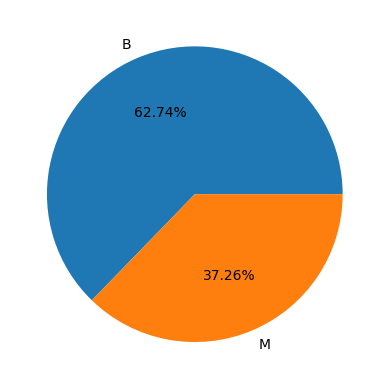

In [113]:
plt.pie(Y.value_counts(),labels=Y.unique(),autopct = '%1.2f%%')

### 3.5.4 StratifiedShuffleSplit

We splits the data using StratifiedShuffleSplit in order to perseve the same labels ratio between train & test.

In [114]:
splitter=StratifiedShuffleSplit(n_splits=1,random_state=12, test_size=0.2) #we can make a number of combinations of split
#But we are interested in only one.

for train,test in splitter.split(X, Y):     #this will splits the index
    X_train = X.iloc[train]
    y_train = Y.iloc[train]
    X_test = X.iloc[test]
    y_test = Y.iloc[test]
print(y_train.value_counts())  
print(y_test.value_counts())

diagnosis
B    285
M    170
Name: count, dtype: int64
diagnosis
B    72
M    42
Name: count, dtype: int64


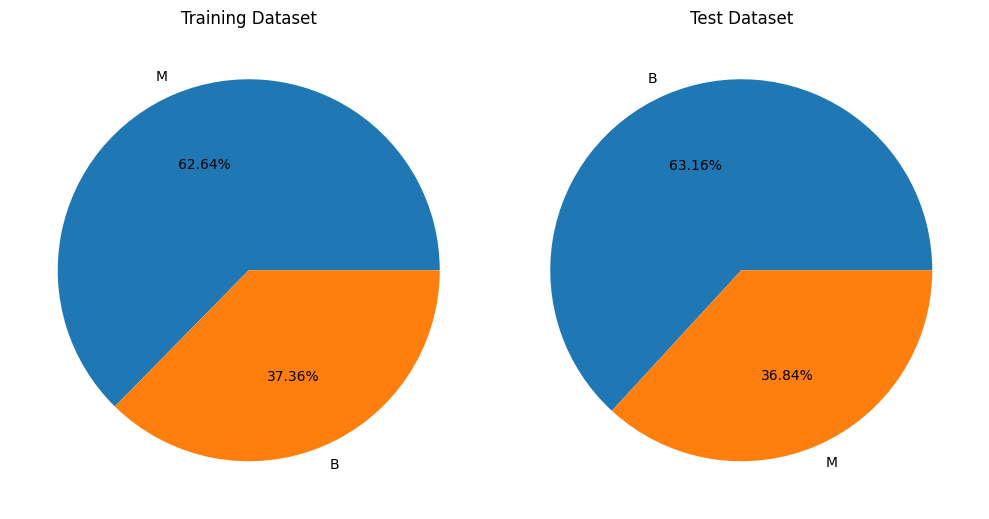

In [115]:
plt.figure(figsize=(10,15))

plt.subplot(121)
plt.pie(y_train.value_counts(),labels=y_train.unique(),autopct = '%1.2f%%')
plt.title('Training Dataset')

plt.subplot(122)
plt.pie(y_test.value_counts(),labels=y_test.unique(),autopct = '%1.2f%%')
plt.title('Test Dataset')

plt.tight_layout()


### 3.5.5 Transforming the y string label using LabelEnconder
we also need to make sure we set the same label encoding for both y_train & y_test

In [116]:
le = preprocessing.LabelEncoder()
trained_le = le.fit(y_train)

y_train = trained_le.transform(y_train)
y_test = trained_le.transform(y_test)

### 3.5.6 Train models with SHAP

Executing KNN on cancer_dataset


Using 114 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 114/114 [03:34<00:00,  1.88s/it]
X has feature names, but KNeighborsClassifier was fitted without feature names


              precision    recall  f1-score   support

           B       0.91      0.97      0.94        72
           M       0.95      0.83      0.89        42

    accuracy                           0.92       114
   macro avg       0.93      0.90      0.91       114
weighted avg       0.92      0.92      0.92       114



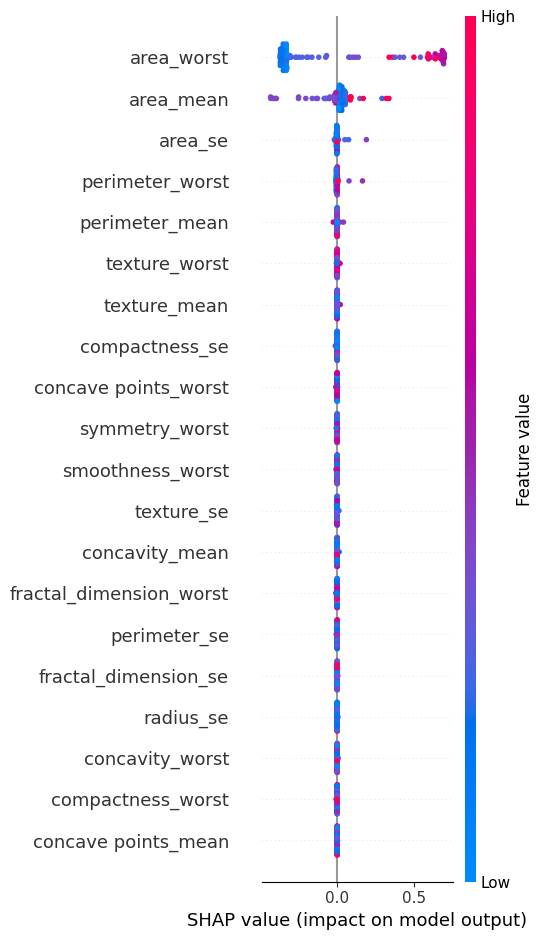

Using 114 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing SVM on cancer_dataset


100%|██████████| 114/114 [10:28<00:00,  5.51s/it]
X has feature names, but SVC was fitted without feature names


              precision    recall  f1-score   support

           B       0.88      0.99      0.93        72
           M       0.97      0.76      0.85        42

    accuracy                           0.90       114
   macro avg       0.92      0.87      0.89       114
weighted avg       0.91      0.90      0.90       114



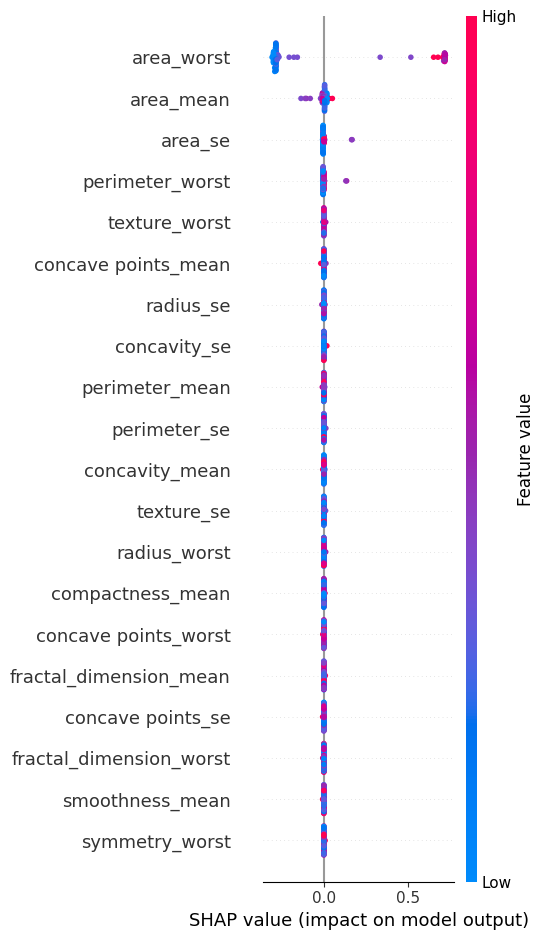

Executing Decision_Tree on cancer_dataset
              precision    recall  f1-score   support

           B       0.93      0.96      0.95        72
           M       0.93      0.88      0.90        42

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



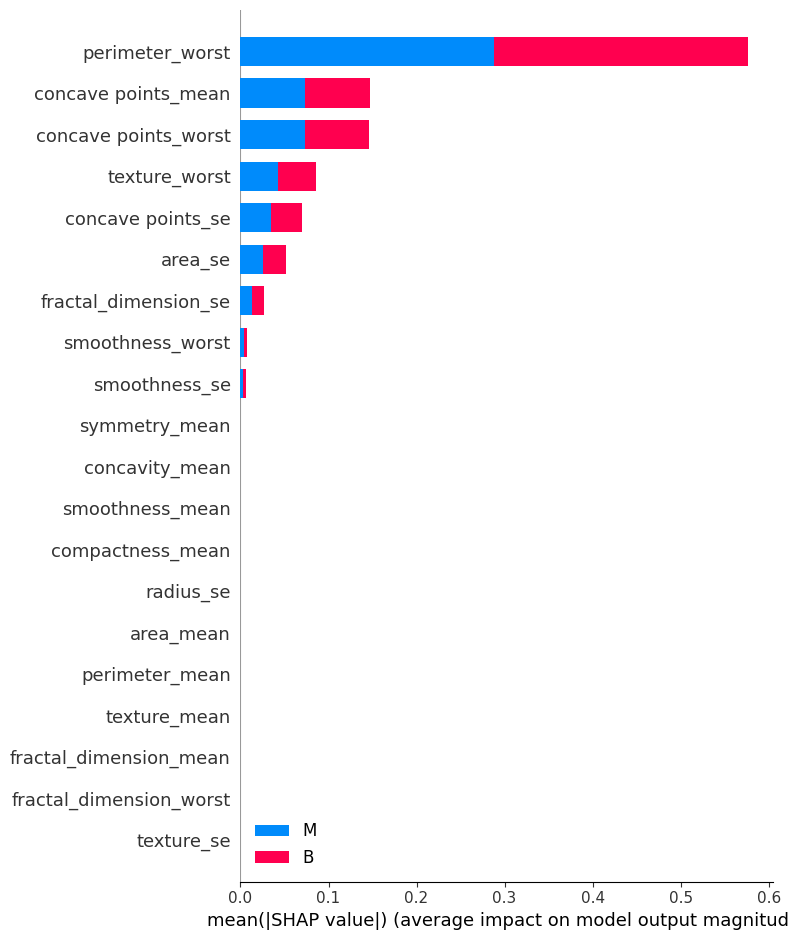

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Using 114 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing Logistic_Regression on cancer_dataset


100%|██████████| 114/114 [02:33<00:00,  1.35s/it]
X has feature names, but LogisticRegression was fitted without feature names


              precision    recall  f1-score   support

           B       0.92      0.94      0.93        72
           M       0.90      0.86      0.88        42

    accuracy                           0.91       114
   macro avg       0.91      0.90      0.90       114
weighted avg       0.91      0.91      0.91       114



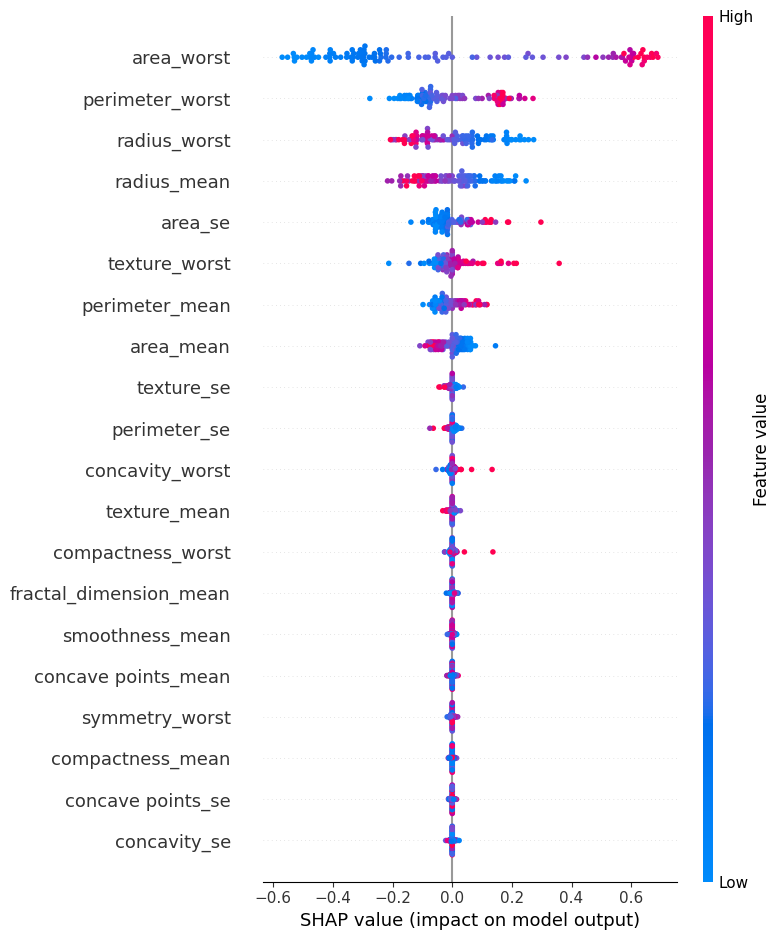

In [117]:
target_strings = Y.unique()
models_train(X_train, y_train, X_test, y_test, CANCER_DATASET, target_strings)

### 3.5.7 XGBOOST

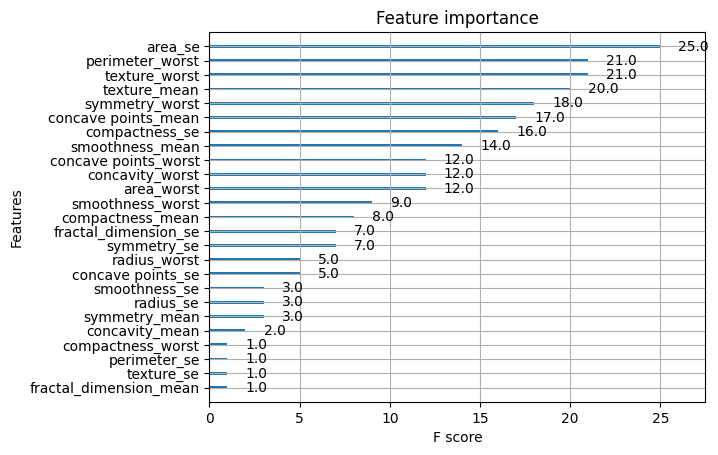

<Figure size 640x480 with 0 Axes>

In [118]:
XGBoostClassifier(X_train, y_train, CANCER_DATASET)

### 3.5.8 Feature Selection
From the graphs above we can see that there are some features that even not appeared in the top 20 important features. Therefore, we choosh to select all features without the following:


*   compactness_worst
*   concave points_se
*   concavity_se
*   fractal_dimension_se
*   radius_mean
*   smoothness_worst
*   symmetry_worst



In [119]:
X_train = X_train.drop(columns=['compactness_worst', 'concave points_se', 'concavity_se', 'fractal_dimension_se', 'radius_mean', 'smoothness_worst', 'symmetry_worst'])
X_test = X_test.drop(columns=['compactness_worst', 'concave points_se', 'concavity_se', 'fractal_dimension_se', 'radius_mean', 'smoothness_worst', 'symmetry_worst'])


Using 114 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing KNN on cancer_dataset


100%|██████████| 114/114 [03:57<00:00,  2.09s/it]
X has feature names, but KNeighborsClassifier was fitted without feature names


              precision    recall  f1-score   support

           B       0.91      0.97      0.94        72
           M       0.95      0.83      0.89        42

    accuracy                           0.92       114
   macro avg       0.93      0.90      0.91       114
weighted avg       0.92      0.92      0.92       114



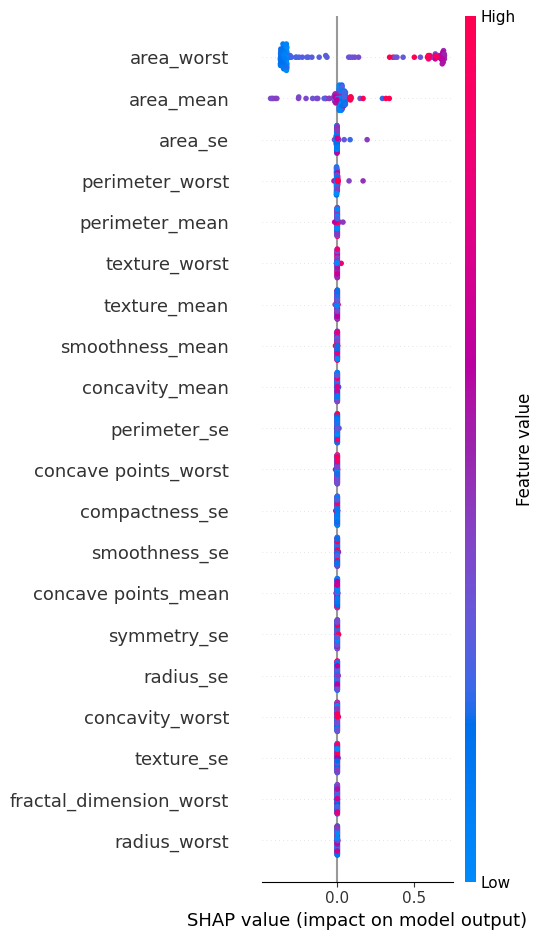

Using 114 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing SVM on cancer_dataset


100%|██████████| 114/114 [16:47<00:00,  8.83s/it]
X has feature names, but SVC was fitted without feature names


              precision    recall  f1-score   support

           B       0.88      0.99      0.93        72
           M       0.97      0.76      0.85        42

    accuracy                           0.90       114
   macro avg       0.92      0.87      0.89       114
weighted avg       0.91      0.90      0.90       114



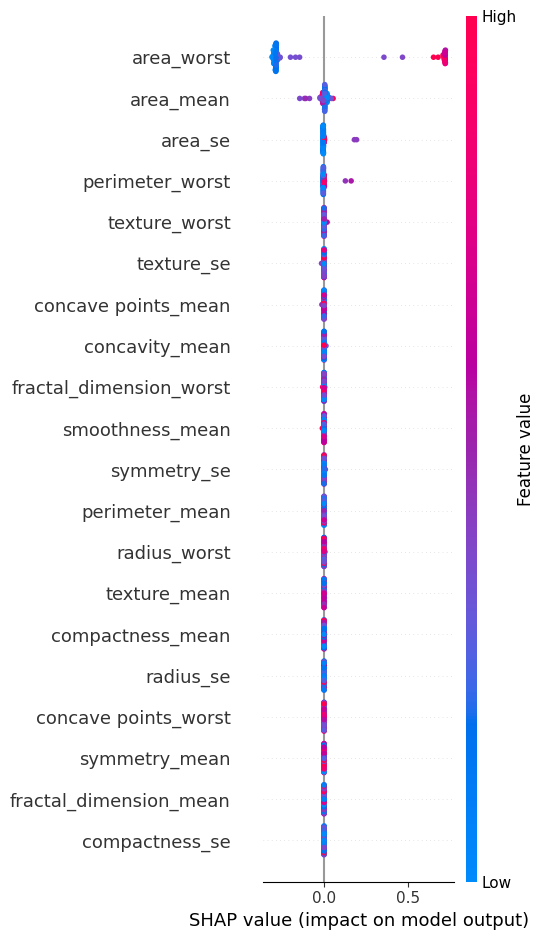

Executing Decision_Tree on cancer_dataset
              precision    recall  f1-score   support

           B       0.92      0.94      0.93        72
           M       0.90      0.86      0.88        42

    accuracy                           0.91       114
   macro avg       0.91      0.90      0.90       114
weighted avg       0.91      0.91      0.91       114



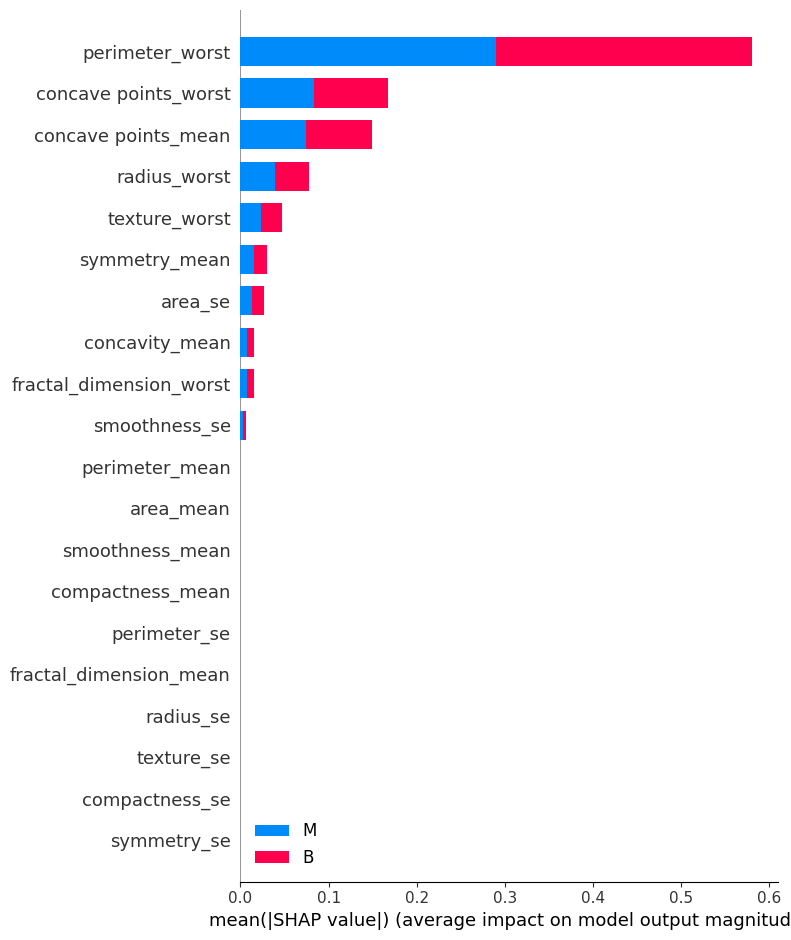

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Using 114 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Executing Logistic_Regression on cancer_dataset


100%|██████████| 114/114 [04:00<00:00,  2.11s/it]
X has feature names, but LogisticRegression was fitted without feature names


              precision    recall  f1-score   support

           B       0.89      0.93      0.91        72
           M       0.87      0.81      0.84        42

    accuracy                           0.89       114
   macro avg       0.88      0.87      0.88       114
weighted avg       0.89      0.89      0.89       114



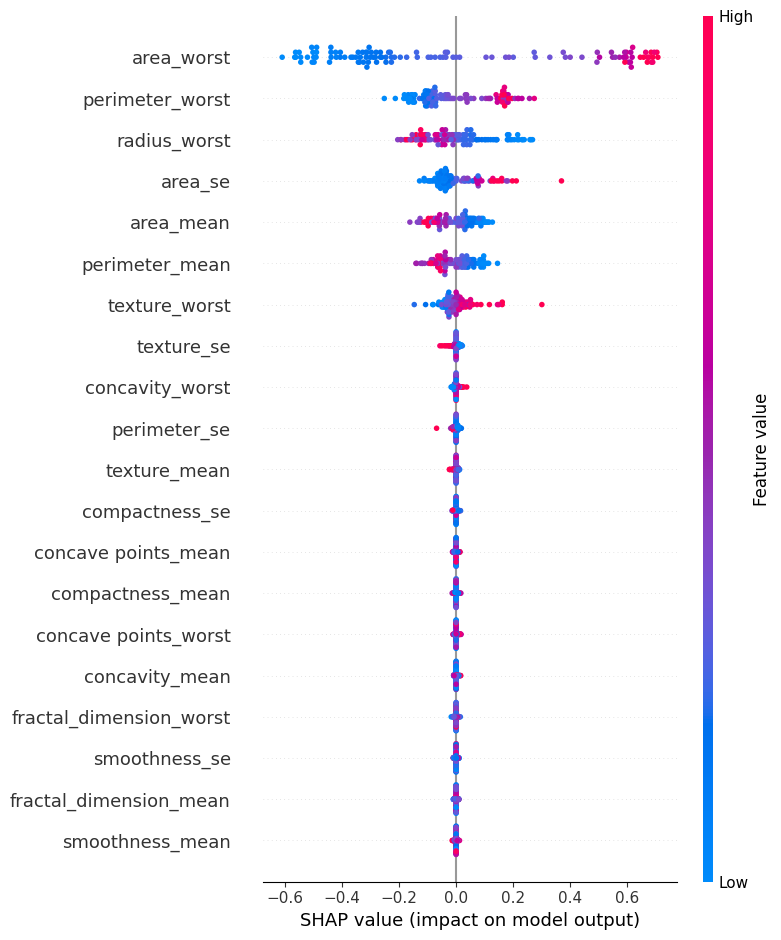

In [120]:
models_train(X_train, y_train, X_test, y_test, CANCER_DATASET, target_strings)